# OPTRAM

In [69]:
import pandas as pd
import utm 
import folium
import re
from pathlib import Path
import geopandas as gpd
from shapely import geometry
from osgeo import gdal
import rasterio
import numpy as np
import numpy.ma as ma
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import datetime
import rasterio as rs
from scipy import stats
import sys
import glob

## REGION OF STUDY


In [70]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

,MAJOR_SUBW,Shape_Leng,Shape_Area,geometry
0,1.0,78272.01636,1.477542e+08,"POLYGON ((605817.380 3515703.128, 605817.505 3..."


In [141]:
def utm_to_latlon(coords, zone_number, zone_letter):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)

def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt


def S2_getSCL(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + 'SCL/' + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except AttributeError: 
        print('Error: File with pattern %s not found' % pattern)

def is_defective_px(SCL_px_val):
    
    if ((SCL_px_val == 4) | (SCL_px_val == 5)): # vegetated OR not_vegetated
        return False
    
    else : 
        return True

# Vectorized version
is_defective_px_vect = np.vectorize(is_defective_px)

# TODO: maybe in the denominator are included alpha values and thus
# computing an undervaluated percentage ?
# TODO type checks 
# TODO shape checks  
def S2_defective_px_perc(scl_raster) : 
    not_defective = sum(~np.array(is_defective_px_vect(scl_raster)))
    perc = not_defective / len(np.ndarray.flatten(scl_raster))
    return perc

In [147]:
if False: # Do not run
    
    fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
    print(S2_getDate(fname))
    
    SCL_file = S2_getSCL(BASE_DIR, date = '20181213')  
    print(SCL_file)

In [110]:
sum([True, True, False])

2

In [72]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    points.append(utm_to_latlon(coords = [x[i], y[i]], zone_number = utm_N, zone_letter = utm_Z))
    
# points

In [73]:
points_rev = [(y,x) for x,y in points]
swrc['geometry'] = geometry.Polygon(points_rev)

In [74]:
m = folium.Map(location=[31.77196086872937, -109.8824988259172], zoom_start=10)
for _, r in swrc.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m

 Shapefile to geojson conversion

In [75]:
swrc.to_crs(epsg=4326)
swrc.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

/home/vyago/miniconda3/envs/spatial/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## LOAD DATA

### Sensor 

In [76]:
names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
l1tdr17 = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/SoilProfileSiteData/l1tdr18.out',
                  sep='\s+', 
                  names = names)

In [78]:
l1tdr17["datetime"] = (
                        pd.to_datetime(l1tdr17['year'] * 1000 + l1tdr17['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(l1tdr17["hr"], unit="h") 
                        +
                        pd.to_timedelta(l1tdr17["mn"], unit="min") 
                      )

In [79]:
l1tdr17.set_index('datetime', inplace = True)
l1tdr17

,site,year,day,hr,mn,SM5,SM15,SM30,SM50,SM75,SM100,SM200
datetime,,,,,,,,,,,,
2018-01-01 00:30:00,3008,2018,1,0,30,6,8,7,6,12,6999,15
2018-01-01 01:00:00,3008,2018,1,1,0,7,8,7,6,12,12,14
2018-01-01 01:30:00,3008,2018,1,1,30,6,7,7,6999,12,11,14
2018-01-01 02:00:00,3008,2018,1,2,0,7,6,7,6,12,10,14
2018-01-01 02:30:00,3008,2018,1,2,30,6,8,7,6999,12,12,15
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-31 22:00:00,3008,2018,31,22,0,6999,6999,6999,6999,6999,6999,6999
2018-01-31 22:30:00,3008,2018,31,22,30,6999,6999,6999,6999,6999,6999,6999
2018-01-31 23:00:00,3008,2018,31,23,0,6999,6999,6999,6999,6999,6999,6999


Its obvious **6999** represent a _no_data_ value.

In [80]:
l1tdr17_fix = l1tdr17.replace(6999, None)

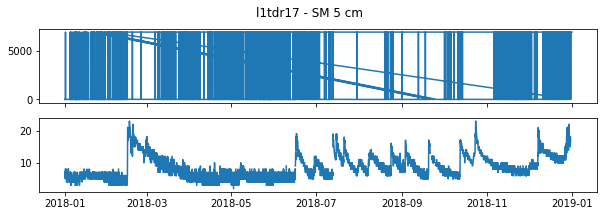

In [81]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (10,3), sharex= True)
fig.suptitle('l1tdr17 - SM 5 cm')
ax1.plot(l1tdr17.loc[:,'SM5'].index, l1tdr17.loc[:,'SM5'])
ax2.plot(l1tdr17_fix.loc[:,'SM5'].index, l1tdr17_fix.loc[:,'SM5'])

### Satellite

Example for df creation of 1 image: 

In [105]:
BASE_DIR = './sen2r/out/'
boa_fp = BASE_DIR + "BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
raster_date = S2_getDate(boa_fp)
scl_fp = S2_getSCL(BASE_DIR, raster_date)


boa = rs.open(boa_fp)
scl = rs.open(scl_fp)
r    = boa.read(3, masked = True)
nir  = boa.read(8, masked = True)
swir = boa.read(11, masked = True)
swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
ndvi = (nir - r)/(nir + r)
STR  = ((1-swir)**2)/(2*swir)
scl  = scl.read(1, masked = True)

The following cell runs a bash command to obtain the sensing acquisition datetime of the satellite images. The invoked script is a R code which uses the sen2r library.

In [14]:
%%bash

cat ./sen2r/sat_sensing_dt.R

# Rscript sat_sensing_dt.R "2021-01-01" "2021-01-10" Walnut-Gulch.geojson 2> /dev/null

args <- commandArgs(trailingOnly = TRUE)
start_dt = args[1] # yyyy-mm-dd
end_dt   = args[2] # yyyy-mm-dd
geojson  = args[3]

time_window <- as.Date(c(start_dt, end_dt))
gj.sf = geojsonsf::geojson_sfc(geojson)
results = sen2r::s2_list(gj.sf, time_interval = time_window)

sensing_dt <- sen2r::safe_getMetadata(results, "sensing_datetime")
sensing_dt


In [15]:
days_offset = 1
start_dt = S2_getDate(boa_fp) - datetime.timedelta(days=days_offset)
end_dt   = S2_getDate(boa_fp) + datetime.timedelta(days=days_offset)

start_dt = start_dt.strftime('%Y-%m-%d')
end_dt   = end_dt.strftime('%Y-%m-%d')

print('Requesting image metadata between %s - %s' % (start_dt, end_dt))

# bash callback: 
dts = ! Rscript ./sen2r/sat_sensing_dt.R $start_dt $end_dt ./sen2r/Walnut-Gulch.geojson 2> /dev/null
dts

Requesting image metadata between 2018-12-12 - 2018-12-14


['S2A_MSIL2A_20181213T175731_N0211_R141_T12SWA_20181213T202707.SAFE ',
 '                                        "2018-12-13 17:57:31 UTC" ']

In [22]:
sensing_datetime = datetime.datetime.strptime(dts[1], '                                        "%Y-%m-%d %H:%M:%S UTC" ')

In [23]:
print(ndvi.data.shape, np.ndarray.flatten(ndvi.data).shape)

(1214, 2607) (3164898,)


In [128]:
S2_defective_px_perc(scl.data)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.05351674e-06, 3.79013756e-06, 0.00000000e+00])

In [144]:
data = {
    'datetime' : sensing_datetime,
    'ndvi' : np.ndarray.flatten(ndvi.data),
    'str'  : np.ndarray.flatten(STR.data),
    'defective_px' : S2_defective_px_perc(np.ndarray.flatten(scl.data)),
    'fpath' : boa_fp,
    'coord_X' :  0, # TODO
    'coord_Y' : 0 # TODO
}

tif_df = pd.DataFrame(data)
tif_df

,datetime,ndvi,str,defective_px,fpath,coord_X,coord_Y
0,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0
1,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0
2,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0
3,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0
4,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0
...,...,...,...,...,...,...,...
3164893,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0
3164894,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0
3164895,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0
3164896,2018-12-13 17:57:31,65535.0,1.0,0.349034,./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulc...,0,0


In [145]:
tif_df.drop(tif_df[tif_df.loc[:,"ndvi"] > 1].index, inplace=True)

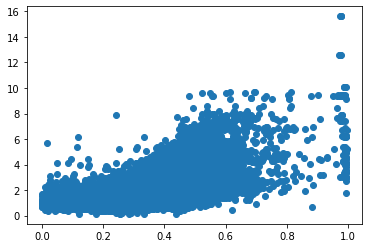

In [146]:
plt.scatter(tif_df.loc[:,"ndvi"], tif_df.loc[:,"str"])

Why so many ndvi values > 1 ??

In [ ]:
boa_fp = r"./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
boa = rs.open(boa_fp) 

In [ ]:
boa.meta

In [ ]:
boa.profile

In [ ]:
boa.bounds

In [ ]:
boa.indexes

----------

In [ ]:
red   = boa.read(3, masked = True)
green = boa.read(4, masked = True)
blue  = boa.read(5, masked = True)
nir   = boa.read(8, masked = True)
swir  = boa.read(11,masked = True)

In [ ]:
type(red)

In [ ]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show(red, ax=axr, cmap='Reds', title='R')
show(green, ax=axg, cmap='Greens', title='G')
show(blue, ax=axb, cmap='Blues', title='B')

In [ ]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

bgr = np.dstack((blue_norm, green_norm, red_norm))
plt.imshow(bgr)

----

In [ ]:
ndvi_fp = "./sen2r/indices/NDMI/S2A2A_20181213_141_Walnut-Gulch_NDMI_10.tif"
ndvi_rs = rs.open(boa_fp) 
ndvi = ndvi_rs.read(1, masked = True)

In [ ]:
show(ndvi, title='NDVI', cmap = "Greens")
ndvi = ndvi / 10000

----

In [ ]:
swir = swir / 10000
STR = ((1-swir)**2)/(2*swir)

In [ ]:
plt.scatter(ndvi, STR)
plt.show()



In [102]:
dts = ! Rscript ./sen2r/sat_sensing_dt.R "2021-01-01" "2021-01-10" ./sen2r/Walnut-Gulch.geojson 2> /dev/null
dts

['S2A_MSIL2A_20210101T175741_N0214_R141_T12SWA_20210101T203251.SAFE ',
 '                                        "2021-01-01 17:57:41 UTC" ',
 'S2A_MSIL2A_20210104T180741_N0214_R041_T12SWA_20210104T203145.SAFE ',
 '                                        "2021-01-04 18:07:41 UTC" ',
 'S2B_MSIL2A_20210106T175729_N0214_R141_T12SWA_20210106T203319.SAFE ',
 '                                        "2021-01-06 17:57:29 UTC" ',
 'S2B_MSIL2A_20210109T180729_N0214_R041_T12SWA_20210109T204254.SAFE ',
 '                                        "2021-01-09 18:07:29 UTC" ']